In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import find_peaks
import scipy.signal.windows as win
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.misc import derivative
from functions_master import *
import warnings

# Suprimir FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [47]:
#plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "stix"#"dejavuserif" 
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['font.size'] = 15; plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15; plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 20; plt.rcParams['ytick.labelsize'] = 20 # Tamanho da fonte dos números do eixo y
plt.rcParams['svg.fonttype'] = 'none'

# Fourier transform defined by scipy

$$y[k]=\sum_{n=0}^{N-1}e^{-2\pi j \frac{kn}{N}}x[n]$$

# UNDERSTANDING LEACKAGE

# Example:


$$y(t) = sin(t)$$

# Result given by mathematica:

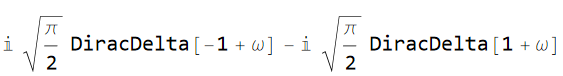

In [29]:
def anim2(n,Lr,Ll,sigma):
    
    
    N = 2**(int(n))
    params_window = ['gaussian',N,sigma]
    window = apply_window(params_window)
    T = np.linspace(Ll,Lr,N)
    Tright = T+abs(Ll-Lr)
    Tleft = T-abs(Ll-Lr)
    dt = T[1]-T[0]
    y = np.sin(T)

    f = plt.figure(figsize=(18,7))

    plt.subplot(121)
    plt.plot(T,y,'k',label='Signal')
    #plt.plot(T,y*window,'g',label='Signal + Window')
    #plt.plot(T,window,'o',label='Window')
    plt.plot(Tright,y,'k',label='Periodic continuation right')
    #plt.plot(Tright,y*window,'g')
    #plt.plot(Tleft,y*window,'g')
    plt.xlabel('Time')
    plt.plot(Tleft,y,'k',label='Periodic continuation left')
    plt.legend(loc='upper right')

    plt.subplot(122)

    nu = sp.fft.fftfreq(N,dt)
    fy = FourierT(y,N)
    fy_window = FourierT(y*window,N)
    #fy2 = FourierT(y,2**12)
    nu2 = sp.fft.fftfreq(2**12,dt)
    plt.plot(nu,abs(fy)/max(abs(fy)),'ko')
    plt.title('Absolute value FFT')
    #plt.plot(nu,abs(fy_window)/np.max(abs(fy_window)),'ro',label=f'FT windowing')
    plt.xlabel(r'$\nu$',fontsize=14)
    #plt.scatter(nu2,abs(fy2), s=0.3, c='blue', marker='o',label='Fourier transform padding')
    plt.xlim(-2,2)
    plt.legend(loc='upper right')
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        n= widgets.FloatSlider(min=0,max=14,value=12,step=1,**opc),
        Lr= widgets.FloatSlider(min=0,max=14,value=12,step=1,**opc),
        Ll= widgets.FloatSlider(min=-14,max=20,value=-3,step=1,**opc),
        sigma= widgets.FloatSlider(min=0,max=1500,value=10,step=1,**opc)
        

        )



interactive(children=(FloatSlider(value=12.0, continuous_update=False, description='n', max=14.0, readout_form…

<function __main__.anim2(n, Lr, Ll, sigma)>

# Example 2:

$$f(t) = e^{-t^2}$$

In [30]:
def anim2(a,n,Lr,Ll):
    
    
    N = 2**(int(n))
    T = np.linspace(Ll,Lr,N)
    Tright = T+abs(Ll-Lr)
    Tleft = T-abs(Ll-Lr)
    dt = T[1]-T[0]
    y = np.exp(-T**2)*np.cos(T*a)

    f = plt.figure(figsize=(14,7))

    plt.subplot(121)
    plt.plot(T,y,'k',label='Signal')
    plt.plot(Tright,y,'r',label='Periodic continuation right')
    plt.xlabel('Time')
    plt.plot(Tleft,y,'b',label='Periodic continuation left')
    plt.legend(loc='upper right')

    plt.subplot(122)
    nu = sp.fft.fftfreq(N,dt)
    fy = FourierT(y,N)
    fy2 = FourierT(y,2**12)
    nu2 = sp.fft.fftfreq(2**12,dt)
    fourier_t = 1/np.sqrt(2)*np.exp(-(2*np.pi*nu)**2/4)
    plt.scatter(nu2,fourier_t/max(fourier_t), s=70, c='black', marker='o',label='Theoretical Fourier transform')
    plt.plot(nu,np.abs(fy)/max(np.abs(fy)),'o',label=f'Fourier transform signal with N = 2^{int(n)}')
    plt.xlabel(r'$\nu$',fontsize=14)
    
    plt.xlim(-2,2)
    plt.legend()
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
         a= widgets.FloatSlider(min=0,max=14,value=12,step=1,**opc),
        n= widgets.FloatSlider(min=0,max=14,value=12,step=1,**opc),
        Lr= widgets.FloatSlider(min=0,max=14,value=12,step=1,**opc),
        Ll= widgets.FloatSlider(min=-14,max=20,value=-3,step=1,**opc)
        

        )



interactive(children=(FloatSlider(value=12.0, continuous_update=False, description='a', max=14.0, readout_form…

<function __main__.anim2(a, n, Lr, Ll)>

# Lab signal

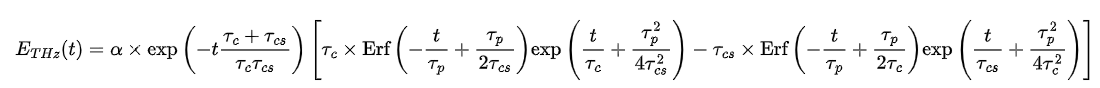

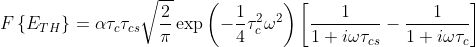

In [58]:
def anim2(τs,τc,τp,M,n,tt):
    
    # Constantes
    τs = τs*1e-14  # en segundos
    τc = τc*1e-14   # en segundos
    τp = τp*1e-15 # en segundos
    c = 299792458
    μe = 1         # valor genérico para la movilidad electrónica
    EDC = 1        # campo eléctrico D
    I0opt = 1      # intensidad de la luz
    n = int(n)

    # # Definir la función I_PC(t)
    # def IPC(t):
    #     term1 = np.exp((τp**2 / (4 * τc**2)) - t / τc) * erfc((τp / (2 * τc)) - (t / τp))
    #     term2 = np.exp((τp**2 / (4 * τs**2)) - t / τs) * erfc((τp / (2 * τs)) - (t / τp))
    #     return (np.sqrt(np.pi) / 2) * μe * EDC * I0opt * (term1 - term2)

    # # Derivar la función respecto al tiempo t
    # def dIPC_dt(t):
    #     return derivative(IPC, t, dx=1e-15)
    
    def E_THz(t):
        # term1 = 
        term2 = τc * erfc((-t / τp) + (τp / (2 * τs))) * np.exp(-(t / τs) + (τp**2 / (4 * τs**2)))
        term3 = -τs * erfc((-t / τp) + (τp / (2 * τc))) * np.exp(-(t / τc) + (τp**2 / (4 * τc**2)))
        
        return (term2 + term3)
    
    def P(w,d,n):
        return np.exp(-1j*w/c*d*n)
    
    def t(nj,nk):
        return 2*nj/(nj+nk)
    
    def r(nj,nk):
        return (nj-nk)/(nj+nk)
    
    def FP(w,nj,nk,nl,d,M):
        term = r(nk,nl)*r(nj,nk)*P(w,d,nk)**2
        return sum(term**m for m in range(0,M+1))

    # def fE_THz(w):
    #     arg1 = 1j*w*τp+τp/(τs)
    #     arg2 = 1j*w*τp+τp/(τc)
    #     term1 =  τp*τc*np.exp(τp**2/(4*τs**2))*np.exp(-τp**2/(2*τs)*(1j*w+1/τs))*(np.exp(arg1**2/4)/arg1)
    #     term2 =  -τp*τs*np.exp(τp**2/(4*τc**2))*np.exp(-τp**2/(2*τc)*(1j*w+1/τc))*(np.exp(arg2**2/4)/arg2)
    #     return term1+term2

    def fE_THz(w):

        arg1 = 1j*w*(τs)+1
        arg2 = 1j*w*(τc)+1

        return np.exp(-1/4*τp**2*w**2)*(1/arg1-1/arg2)
    

    
    def taylor_fE_THz(w,n):

        arg1 = 1j*w*(τs)
        arg2 = 1j*w*(τc)

        return np.exp(-1/4*τp**2*w**2)*(sum(arg1**i-arg2**i for i in range(0,n+1)))

    # Rango de tiempo en segundos
    N = 2**10
    T = 10
    t_vals = np.linspace(-T/6*1e-12, T/2*1e-12, N)
    dt = t_vals[1]-t_vals[0]

    # Evaluar las funciones en el rango de tiempo
    # IPC_vals = IPC(t_vals)
    # dIPC_vals = dIPC_dt(t_vals)

    f = plt.figure(figsize=(14,12))
    Ethz = E_THz(t_vals)
    
    # Graficar ambas funciones
    plt.subplot(221)
    #plt.plot(t_vals*1e12, IPC_vals/max(IPC_vals), label="I_PC(t)", color="blue", linewidth=2)
    #plt.plot(t_vals*1e12, dIPC_vals/max(dIPC_vals),'o', label="dI_PC/dt")
    plt.plot(t_vals*1e12,Ethz/max(E_THz(Ethz)), color="red", linestyle="--", linewidth=2)
    plt.xlabel("t (s)")
    plt.ylabel("$E_{THz}$")
    plt.legend() 
    #plt.title("I_PC(t) y su derivada respecto al tiempo")
    plt.grid(True)
    # plt.show()

    plt.subplot(222)

    
    nu = sp.fft.fftfreq(N,dt)
    filt = (nu*1e-12 > 0) & (nu*1e-12 < 5)
    fy_comp = FourierT(Ethz,N)
    fy_comp = fy_comp#[filt]
    teor_fE_THz = fE_THz(2*np.pi*nu)
    teor_fE_THz = teor_fE_THz#[filt]
    nu = nu#[filt]*1e-12



    # plt.plot(nu[filt]*1e-12,np.abs(fy_comp[filt])/max(np.abs(fy_comp)),'rs',label='Computational Fourier transform')
    
    plt.plot(nu[filt]*1e-12,np.abs(taylor_fE_THz(2*np.pi*nu,n)[filt])/max(np.abs(np.abs(taylor_fE_THz(2*np.pi*nu,n)))),'--ko',label='Analitical Fourier transform')
    plt.plot(nu[filt]*1e-12,np.abs(teor_fE_THz[filt])/max(np.abs(teor_fE_THz)),'ro',label='Approx Fourier transform')
    #lt.yscale('log')
    plt.legend()
    plt.xlabel(r"$\nu$ [THz]")
    #plt.xlim(0,10)
    # PULSO LUEGO DE ATRAVES LA MUESTRA.


    plt.subplot(223)
    n0 = 1
    n1 = 2.6
    d = 0.50*1e-3
    fy_comp_mat = fy_comp*t(n0,n1)*t(n1,n0)*P(nu,d,n1)*FP(nu,n0,n1,n0,d,int(M))
    invers_fy_comp_mat = FourierI(fy_comp_mat,N)
    filter_t = t_vals*1e12 < tt
    invers_fy_comp_mat_rec = invers_fy_comp_mat[filter_t]
    finvers_fy_comp_mat_rec = FourierT(invers_fy_comp_mat_rec,N)
    plt.plot(t_vals*1e12,(invers_fy_comp_mat)/max(abs(invers_fy_comp_mat)),'k',label='Signal with reflection')
    plt.plot(t_vals[filter_t]*1e12,invers_fy_comp_mat_rec/max(abs(invers_fy_comp_mat_rec)),'o',label='Windowed signal')
    plt.xlabel("t (s)")
    
    plt.legend()
    #plt.yscale('log')

    plt.subplot(224)


    plt.plot(nu[filt]*1e-12,np.abs(fy_comp_mat[filt])/max(np.abs(fy_comp_mat[filt])),'--ro',label='Signal with reflections')
    plt.plot(nu[filt]*1e-12,np.abs(finvers_fy_comp_mat_rec[filt])/max(np.abs(finvers_fy_comp_mat_rec[filt])),'--ko',label='Signal with rectangle window')
    plt.plot(nu[filt]*1e-12,np.abs(teor_fE_THz[filt])/max(np.abs(teor_fE_THz)),'--bs',label='Fourier transform of signal without reflection0s')
    plt.xlabel(r"$\nu$ [THz]")
    plt.yscale('log')
    plt.legend()
    #plt.xlim(0,10)





opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        τs= widgets.FloatSlider(min=0,max=100,value=1,step=1,**opc),
        τc= widgets.FloatSlider(min=0,max=14,value=0.740,step=0.01,**opc),
        τp= widgets.FloatSlider(min=0,max=500,value=97,step=1,**opc),
        M = widgets.FloatSlider(min=0,max=10,value=1,step=1,**opc),
        n = widgets.FloatSlider(min=0,max=10,value=1,step=1,**opc),
        tt = widgets.FloatSlider(min=0,max=10,value=1.6,step=0.01,**opc)
        

        )

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='τs', readout_format='.3f', …

<function __main__.anim2(τs, τc, τp, M, n, tt)>

# Air + Water

In [32]:
x1,x2 = 0.15,1.05

path_air1 = r'C:\Users\usuario_trabajo\Desktop\physics\TESIS\paper_window\Air+Water'
archivos = os.listdir(path_air1)

labels = [extraer_humedad(nombre_archivo) for nombre_archivo in archivos]
# Filtrar solo archivos (excluyendo carpetas)
archivos = [os.path.join(path_air1, archivo) for archivo in archivos if os.path.isfile(os.path.join(path_air1, archivo))]

In [33]:
def anim2(τs,τc,τp,a):

    
    f = plt.figure(figsize=(15,5))

    plt.subplot(121)
    for j,arc in enumerate(archivos):
        
        
        t, y = extrac_data_time(os.path.join(path_air1, arc))


        # plt.plot(t, (y)/max(y),label = f'{labels[j]} %')
    # print(np.argmax(y))
        # plt.xlabel('t [ps]')
    # Constantes
    τs = τs*1e-14*1e12  # en segundos
    τc = τc*1e-14*1e12  # en segundos
    τp = τp*1e-15*1e12 # en segundos
    t_dis = (t-t[np.argmax(y)])*1e-1
    ethz = E_THz(t_dis,τs,τc,τp)*np.cos(t*a)

    plt.plot(t,ethz.values/max(ethz.values),'k',label='THz field Vacuum')
    plt.xlim(min(t),380)
    plt.xlabel('t [ps]')
    plt.ylabel('E [t]')
    plt.legend(loc='upper right')



opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        τs= widgets.FloatSlider(min=0,max=5,value=0.333,step=0.001,**opc),
        τc= widgets.FloatSlider(min=0,max=14,value=0.680,step=0.01,**opc),
        τp= widgets.FloatSlider(min=0,max=500,value=39.000,step=1,**opc),
        a= widgets.FloatSlider(min=0,max=5,value=1,step=0.01,**opc)
        )

interactive(children=(FloatSlider(value=0.333, continuous_update=False, description='τs', max=5.0, readout_for…

<function __main__.anim2(τs, τc, τp, a)>

In [34]:
# Parameters for fitting
nu11, nu21 = 0.4, 0.7
p01 = [1,0.25,0.556,0.01]
nu12, nu22 = 0.6, 0.9
p02=[1,0.25,0.75,0.01]
nu13, nu23 = 0.9, 1.075
p03=[1,0.25,0.98,0.01]

initial_seed = [p01,p02,p03]
nus1 = [nu11,nu12,nu13]
nus2 = [nu21,nu22,nu23]

In [35]:
nu_filtradas1, ref = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[-1]))
# f = plt.figure(figsize=(15,5))

nu1, nu2 = 0.9, 1.075

parameters = []
parameters_hum = np.zeros((len(archivos)-1,4))

# colors = ['b','r','k','g','c']
kk = 0

for kk in range(len(nus1)):
    cont = 0
    parameters_hum = np.zeros((len(archivos)-1,4))

    for j,arc in enumerate(archivos):

        if j!=len(archivos)-1:
            nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
            filter_omega = (nu_filtradas1 > nus1[kk]) & (nu_filtradas1 < nus2[kk])
            params = fit_trans_model(nu_filtradas1,np.abs(fourier1/ref),nus1[kk], nus2[kk],p0=initial_seed[kk])
            parameters_hum[cont,0] = params[0]
            parameters_hum[cont,1] = params[1]
            parameters_hum[cont,2] = params[2]
            parameters_hum[cont,3] = params[3]

            cont+= 1

    parameters.append(parameters_hum)

In [36]:
def anim2(τs,τc,τp,a):

    
    f = plt.figure(figsize=(15,5))

    plt.subplot(121)
    for j,arc in enumerate(archivos):
        
        
        t, y = extrac_data_time(os.path.join(path_air1, arc))


        plt.plot(t, (y)/max(y),label = f'{labels[j]} %')
    # print(np.argmax(y))
        # plt.xlabel('t [ps]')
    # Constantes
    τs = τs*1e-14*1e12  # en segundos
    τc = τc*1e-14*1e12  # en segundos
    τp = τp*1e-15*1e12 # en segundos
    t_dis = (t-t[np.argmax(y)])*1e-1
    ethz = E_THz(t_dis,τs,τc,τp)*np.cos(1*t*a)

    plt.plot(t,ethz.values/max(ethz.values),'k',label='THz field Vacuum')
    plt.xlim(min(t),400)
    plt.xlabel('t [ps]')
    plt.ylabel('E [t]')
    plt.legend(loc='upper right')

    plt.subplot(122)
    N = 2**12
    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
    fourier = FourierT(ethz.values,N)[1:len(nu)//k]
    nu = nu[1:len(nu)//k]
    xmin, xmax = x1,x2
    mask = (nu >= xmin) & (nu <= xmax)
    nu_filtradas = nu[mask]
    fourier = fourier[mask]

    plt.plot(nu_filtradas,np.abs(fourier)/max(np.abs(fourier)),'k')

    for j,arc in enumerate(archivos):

        nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
        plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[j]} %')
        plt.xlabel('$\omega$ [THz]')
        plt.ylabel(r'Absolute value FFT')
        #plt.yscale('log')

    f = plt.figure(figsize=(15,5))

    nu_filtradas1, ref = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[-1]))
    colors = ['b','r','k','g','c']
    kk = 0
    
    
    for j,arc in enumerate(archivos):

        if j!=len(archivos)-1:
            nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
            plt.subplot(121)
            signal_exp = np.abs(fourier1/ref)
            plt.plot(nu_filtradas1, signal_exp ,color=colors[kk],label = f'{labels[j]} %')
            plt.ylabel(r'Transmitance')
            plt.xlabel('$\omega$ [THz]')
            
            plt.subplot(122)
            signal = concat_trans(nu_filtradas1,parameters,j)
            dist = signal[0]-signal_exp[0]  
            plt.plot(nu_filtradas1,signal-dist,color=colors[kk],label = f'{labels[j]} % fit')

            kk+=1

    # plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[-1]} %')
    
    
    plt.legend()



opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        τs= widgets.FloatSlider(min=0,max=5,value=5,step=0.001,**opc),
        τc= widgets.FloatSlider(min=0,max=14,value=0.420,step=0.01,**opc),
        τp= widgets.FloatSlider(min=0,max=500,value=48,step=1,**opc),
        a= widgets.FloatSlider(min=0,max=5,value=1.7,step=0.01,**opc)
        )

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='τs', max=5.0, readout_forma…

<function __main__.anim2(τs, τc, τp, a)>

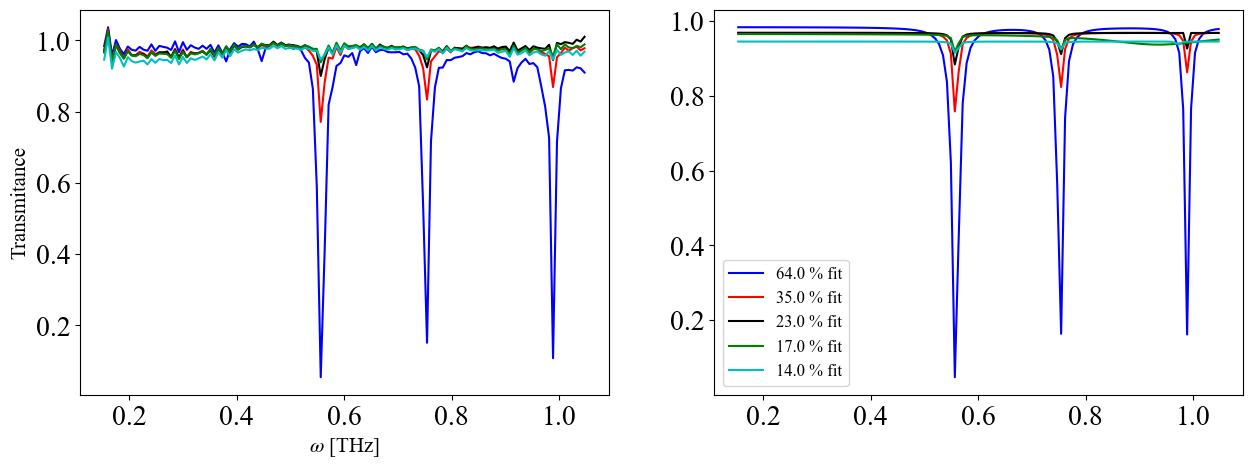

In [37]:
f = plt.figure(figsize=(15,5))

transmitances = []
nu_filtradas1, ref = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[-1]))
colors = ['b','r','k','g','c']
kk = 0


for j,arc in enumerate(archivos):

    if j!=len(archivos)-1:
        nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, arc))
        plt.subplot(121)
        signal_exp = np.abs(fourier1/ref)
        plt.plot(nu_filtradas1, signal_exp ,color=colors[kk],label = f'{labels[j]} %')
        plt.ylabel(r'Transmitance')
        plt.xlabel('$\omega$ [THz]')
        
        plt.subplot(122)
        signal = concat_trans(nu_filtradas1,parameters,j)
        dist = signal[0]-signal_exp[0]  
        transmitances.append(signal-dist)
        plt.plot(nu_filtradas1,signal-dist,color=colors[kk],label = f'{labels[j]} % fit')

        kk+=1

# plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[-1]} %')


plt.legend()


In [38]:
t, y = extrac_data_time(os.path.join(path_air1, archivos[0]))
    # plt.plot(t, (y)/max(y),label = f'{labels[j]} %')
# Constantes
# τs = 0.333*1e-14*1e12  # en segundos
# τc = 0.680*1e-14*1e12  # en segundos
# τp = 39*1e-15*1e12 # en segundos
τs = 5*1e-14*1e12  # en segundos
τc = 0.420*1e-14*1e12  # en segundos
τp = 48*1e-15*1e12 # en segundos
t_dis = (t-t[np.argmax(y)])*1e-1
ethz = E_THz(t_dis,τs,τc,τp)*np.exp(1j*1.710*t)

N = 2**12
n_k = 15
nu = sp.fft.fftfreq(N, 1/30)

# fouriert_thz = FourierT(ethz.values,N)[1:len(nu)//k]
fouriert_thz_full = FourierT(ethz.values,N)
nu1 = nu[1:len(nu)//n_k]
xmin, xmax = x1,x2
mask = (nu1 >= xmin) & (nu1 <= xmax)
nu_filtradas = nu1[mask]
# fouriert_thz = fouriert_thz[mask]

# Calcular la cantidad de puntos que se necesitan para completar el tamaño original
puntos_izquierda = np.where(nu == nu_filtradas[0])[0][0]
puntos_derecha = len(nu) - (puntos_izquierda + len(nu_filtradas))

c:\Users\usuario_trabajo\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\usuario_trabajo\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


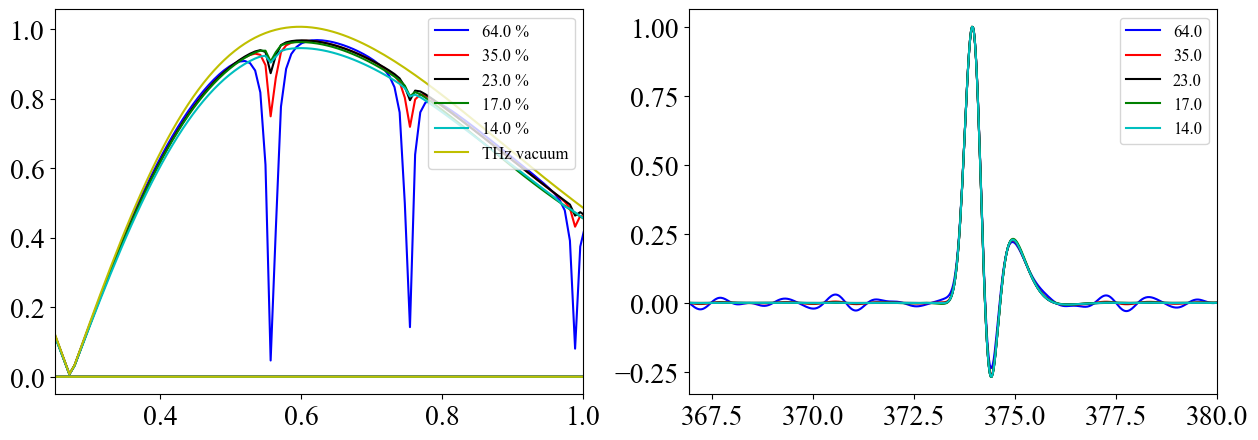

In [39]:
f = plt.figure(figsize=(15,5))
plt.subplot(121)

transmitances_new = []
for cont,transm in enumerate(transmitances):

    k_new = np.pad(transm, (puntos_izquierda, puntos_derecha), mode='constant', constant_values=(transm[0],transm[-1]))
    transmitances_new.append(k_new)
    # print(cont)
    plt.plot(nu,np.abs(fouriert_thz_full)/max(np.abs(fouriert_thz_full))*k_new ,color=colors[cont],label=f'{labels[cont]} %')
    plt.xlim(0.25,1)

plt.plot(nu,np.abs(fouriert_thz_full)/max(fouriert_thz_full),'y',label='THz vacuum')
plt.legend(loc='upper right')
#plt.xlim(0,2)


plt.subplot(122)
time_array = np.linspace(min(t),max(t),N)
plt.plot(time_array,FourierI(fouriert_thz_full,N)/max(FourierI(fouriert_thz_full,N)),'k')


for cont,k in enumerate(transmitances_new):
    time_domain = FourierI(fouriert_thz_full*k,N)
    plt.plot(time_array,time_domain/max(time_domain),color=colors[cont],label=labels[cont])
    plt.xlim(min(time_array),380)

plt.legend()

# Simplified model

In [40]:
def E(t,a,w):
    return np.exp(-a*t**2)*np.exp(-1j*w*t)




def anim2(a,w):

    
    f = plt.figure(figsize=(15,5))


    t, y = extrac_data_time(os.path.join(path_air1, archivos[0]))

    plt.subplot(121)
    #plt.plot(t, y/max(y),label = f'{labels[0]} % experimental data')
    plt.xlabel('t [ps]')
    t_label = (t-t[np.argmax(y)])
    E_field = np.exp(-a*t_label**2)*np.exp(1j*w*t)
    plt.plot(t,np.real(E_field)/max(np.abs(E_field)),'k',label='theoretical')
    plt.legend()
    plt.xlim(min(t),400)

    plt.subplot(122)
    N = 2**12
    k = 15
    nu1 = sp.fft.fftfreq(N, 1/30)
    fourier = FourierT(E_field.values,N)
    # nu = nu1[1:len(nu)//k]
    # xmin, xmax = x1,x2
    # mask = (nu >= xmin) & (nu <= xmax)
    # nu_filtradas = nu[mask]
    # fourier = fourier

    new_fiedl = fourier/max(np.abs(fourier))*transmitances_new[0]

    plt.plot(nu1,np.abs(new_fiedl),'o',color=colors[0],label='Theoretical')
    nu_filtradas1, fourier1 = extrac_data_freq(x1,x2,os.path.join(path_air1, archivos[0]))
    plt.plot(nu_filtradas1, np.abs(fourier1)/max(np.abs(fourier1)),label = f'{labels[0]} % Experimental')
    plt.xlim(min(nu_filtradas1),1)
    plt.xlabel('$\omega$ [THz]')
    plt.legend()


    f = plt.figure(figsize=(15,5))
    time_array = np.linspace(min(t),max(t),N)
    plt.plot(time_array,FourierI(new_fiedl,N)/max(FourierI(new_fiedl,N)),'k',label='Theoretical pulse with air+water')
    #plt.plot(t,np.real(E_field)/max(np.abs(E_field)),'r',label='Theoretical pulse without air')
    plt.xlim(min(t),400)
    plt.xlabel('t [ps]')
    plt.legend()



opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        a= widgets.FloatSlider(min=0,max=5,value=1.258,step=0.001,**opc),
        w= widgets.FloatSlider(min=0,max=14,value=3.540,step=0.01,**opc),
        )

interactive(children=(FloatSlider(value=1.258, continuous_update=False, description='a', max=5.0, readout_form…

<function __main__.anim2(a, w)>

# Propagation of light through PbTe

In [2]:
carpeta = rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20'

carpeta_ref = rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\substrate\20-20'

archivos_dat = glob.glob(os.path.join(os.path.join(carpeta,'carpeta1'), '*.dat'))


archivos_dat_ref = glob.glob(os.path.join(os.path.join(carpeta_ref,'carpeta1'), '*.dat'))

# Elimina cada archivo
for archivo in archivos_dat:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')

for archivo in archivos_dat_ref:
    os.remove(archivo)
    #print(f'Archivo {archivo} eliminado.')



warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
N = 1 # Variable para agrupar datos de temperatura

convert_dats(carpeta,N)
convert_dats(carpeta_ref,N)

Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_10.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_20.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_40.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_60.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_80.0K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbTe\20-20\carpeta1\Average_100.0K.dat generado en C:\Users\usuario_trabajo\Desk

In [4]:
#path_analisis = r'C:\Users\usuario_trabajo\Desktop\physics\TESIS\20-20\20-20\carpeta1'
path_analisis = os.path.join(carpeta,'carpeta1')
path_analisis_ref = os.path.join(carpeta_ref,'carpeta1')

# Obtener lista de archivos .dat en la carpeta
archivos = os.listdir(path_analisis)
archivos2 = os.listdir(path_analisis_ref)

# Filtrar y ordenar los archivos por la temperatura
archivos_ordenados_s = sorted(
    archivos,
    key=lambda x: extraer_temperatura(x)
)

archivos_ordenados_ref = sorted(
    archivos2,
    key=lambda x: extraer_temperatura(x)
)

In [5]:
colors = plt.cm.jet(np.linspace(0, 1, len(archivos_ordenados_s)))[::-1]


In [6]:
# bis = [0.02,0.03,0.06,0.07,0.1,0.15] # Porcentaje de Bismuto.

delta_ls = {"20-20": 0.446- 0.360, # Substrato - mostra. (Mostra = substrato + FILM ) FILM -> OBJETO DE ESTUDIO. BaF2
}  # SINN BISMUTO.

sample = "20-20"
d = 0.0016

In [7]:
def FourierT2(f,N):
    return np.conj(sp.fft.fft(f.values,n=N))


In [8]:
#plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "stix"#"dejavuserif" 
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['font.size'] = 15; plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15; plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 25; plt.rcParams['ytick.labelsize'] = 20 # Tamanho da fonte dos números do eixo y
plt.rcParams['svg.fonttype'] = 'none'

In [9]:
def anim2(left,right_sample,right_subs,index,correc_subs,desv):
    
    f = plt.figure(figsize=(14, 15),dpi=200)

    N = 2**12

    global nk0, nk1, nk2
    nk0 = left
    nk1 = right_sample
    nk2 = right_subs

    path_signal = os.path.join(path_analisis,archivos_ordenados_s[int(index)])
    path_ref = os.path.join(path_analisis_ref ,archivos_ordenados_ref[int(index)])
    # params_window = ['gaussian', desv]
   # params_window = ['flattop']
    params_window = ['barthann']


    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(path_signal,path_ref,left,right_sample,right_subs,params_window)

    x,y = getFilterdata(path_signal,right_sample,left)
    x_ref,y_ref = getFilterdata(path_ref,right_subs,left)

    # Datos substrate
    y_subs_ventana = pd.Series(y_substrate_padding*ventana)
    y_signal_ventaneada = pd.Series(y_signal_ventaneada*ventana)


    plt.subplot(321)
    plt.plot(x,y/max(y),'k',label='without window')
    plt.plot(x,ventana,'r',label='Barthann window')
    plt.plot(x,y_signal_ventaneada/max(y_signal_ventaneada),'o',color = colors[-int(index)],label='Signal + window')
    plt.xlabel('t [ps]')
    plt.title('Signal')
    plt.legend()

    plt.subplot(322)
    plt.plot(x_ref,y_ref/max(y_ref),'k',label='without window')
    #plt.plot(x,ventana,'r',label='barthann window')
    plt.plot(x,y_subs_ventana/max(y_subs_ventana),'o',color = colors[-int(index)],label='Substrate + window')
    plt.xlabel('t [ps]')
    plt.title('Reference')
    plt.legend()
    
    
    

    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
        # Aplicar ventana de Hamming a la señal
   
    # Transformada de Fourier de las señales
    fft_y_signal_ventaneada = FourierT2(y_signal_ventaneada,N)[1:len(nu)//k]
    fft_y_subs_ventaneada = FourierT2(y_subs_ventana,N)[1:len(nu)//k]

    fft_y_signal= FourierT2(y,N)[1:len(nu)//k]
    fft_y_subs = FourierT2(y_ref,N)[1:len(nu)//k]


    fft_window = FourierT2(pd.Series(ventana),N)[1:len(nu)//k]

     # Filtrar las frecuencias
    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.2, 1.0
    mask = (nu >= xmin) & (nu <= xmax)
    nu_filtradas = nu[mask]
    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]

    fft_y_signal= fft_y_signal[mask]
    fft_y_subs = fft_y_subs[mask]
    fft_window = fft_window[mask]

    global delta_ls_corr
    delta_ls_corr = delta_ls[sample] + correc_subs
    T_ventana = (fft_y_signal_ventaneada/fft_y_subs_ventaneada)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)*np.exp(1j*2*np.pi*nu_filtradas*phase*1/30)
    T = (fft_y_signal/fft_y_subs)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)
    n = 2.6
    ep_con = 1j*(1+n)*((1/T_ventana)-1)*c/(2*np.pi*nu_filtradas*d)-n
    ep_sin = 1j*(1+n)*((1/T)-1)*c/(2*np.pi*nu_filtradas*d)-n

    plt.subplot(323)
    plt.plot(nu_filtradas, np.abs(fft_y_signal_ventaneada)/max(np.abs(fft_y_signal_ventaneada)), label='FFT signal with window',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.abs(fft_y_signal)/max(np.abs(fft_y_signal)), 'k',label='without window ')
    #plt.plot(nu_filtradas,np.abs(fft_window)/max(fft_window),'r',label='FFT window')
    
    plt.ylabel('Absoluto value Fourier Transform')
    plt.yscale('log')
    #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    plt.legend()

    plt.subplot(324)
    plt.plot(nu_filtradas, np.abs(fft_y_subs_ventaneada), label='FFT SUBSTRATE',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.abs(fft_y_subs), 'k',label='without window ')
    plt.yscale('log')
    #plt.ylabel('Absolute Value Fourier Transform',fontsize=15)
    #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    plt.legend()



    plt.subplot(325)
    plt.plot(nu_filtradas, np.imag(ep_con)*1e-3, label='with window '+str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.imag(ep_sin)*1e-3, 'k',label='without window '+str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K')
    #plt.yscale('log')
    plt.ylabel(r'$\epsilon^{(2)}\times 10^{-3}$')
    plt.xlabel(r'$\omega$ [THz]')
    plt.legend()


    plt.subplot(326)
    plt.plot(nu_filtradas, np.real(ep_con)*1e-3, label='with window '+str(extraer_temperatura(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)])
    plt.plot(nu_filtradas, np.real(ep_sin)*1e-3, 'k',label='without window ')
    plt.ylabel(r'$\epsilon^{(1)}\times 10^{-3}$')
    plt.xlabel(r'$\omega$ [THz]')
    #plt.title(f'Delta sample real:{round(delta_ls[sample],4)}, Delta sample correg: {round(delta_ls_corr,5)}')
    plt.legend()

    plt.savefig("my_figure.png", dpi=300, bbox_inches='tight', format='png')
    plt.show()
  

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        left= widgets.FloatSlider(min=350,max=420,value=380,step=0.1,**opc),
        right_sample= widgets.FloatSlider(min=350,max=420,value=392,step=0.1,**opc),
        right_subs= widgets.FloatSlider(min=350,max=420,value=390,step=0.1,**opc),
        index= widgets.FloatSlider(min=0,max=len(archivos_ordenados_s)-1,value=6,step=1,**opc),
        correc_subs=widgets.FloatSlider(min=-delta_ls[sample],max=delta_ls[sample],value=-0.021,step=0.001,**opc),
        desv = widgets.FloatSlider(min=0,max=200,value=100,step=0.001,**opc)

        )

interactive(children=(FloatSlider(value=380.0, continuous_update=False, description='left', max=420.0, min=350…

<function __main__.anim2(left, right_sample, right_subs, index, correc_subs, desv)>

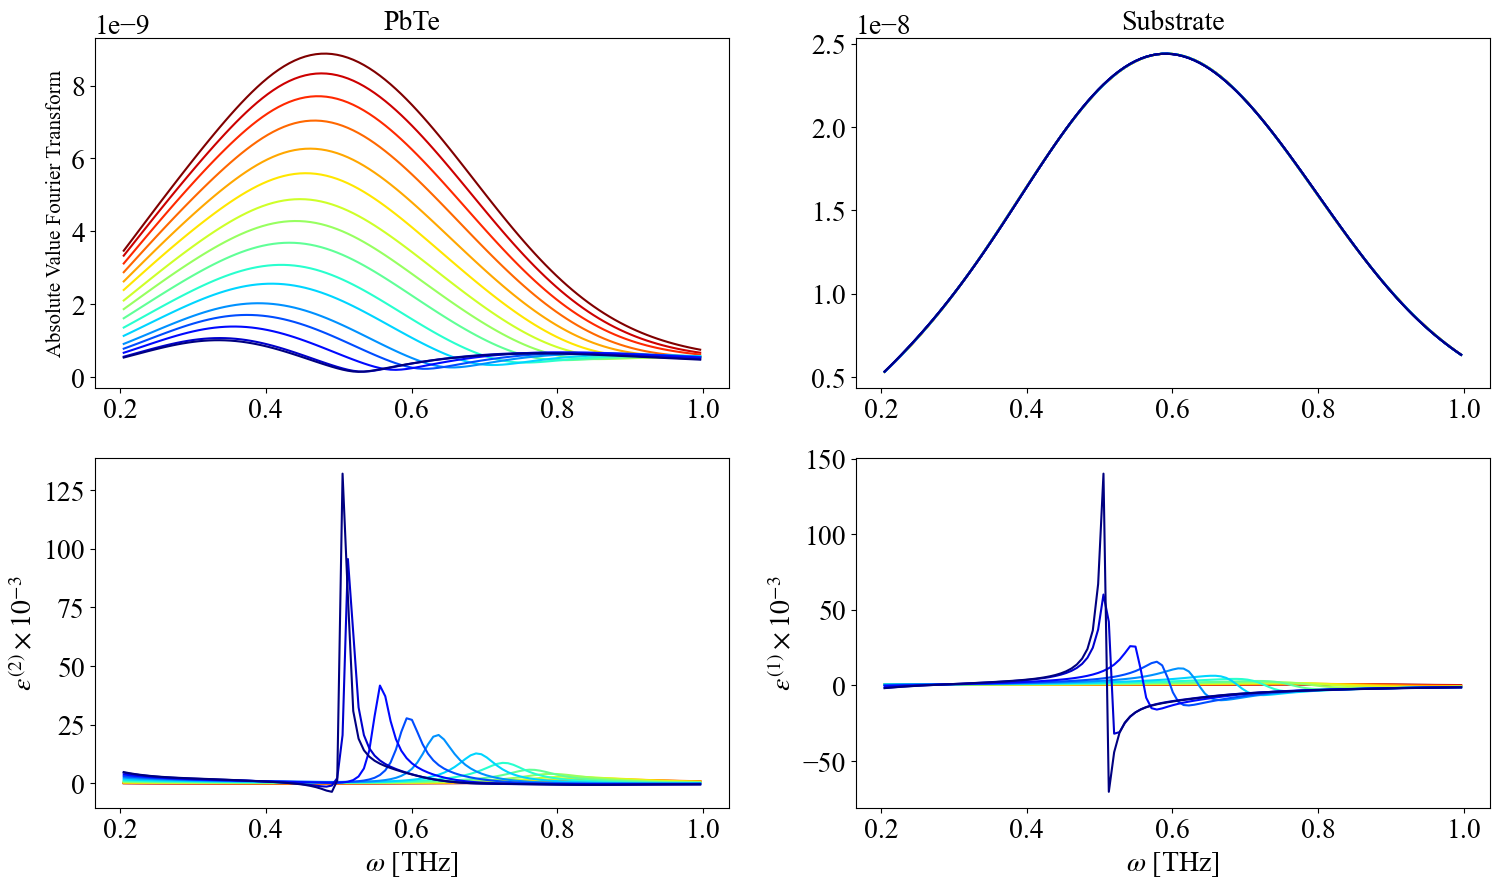

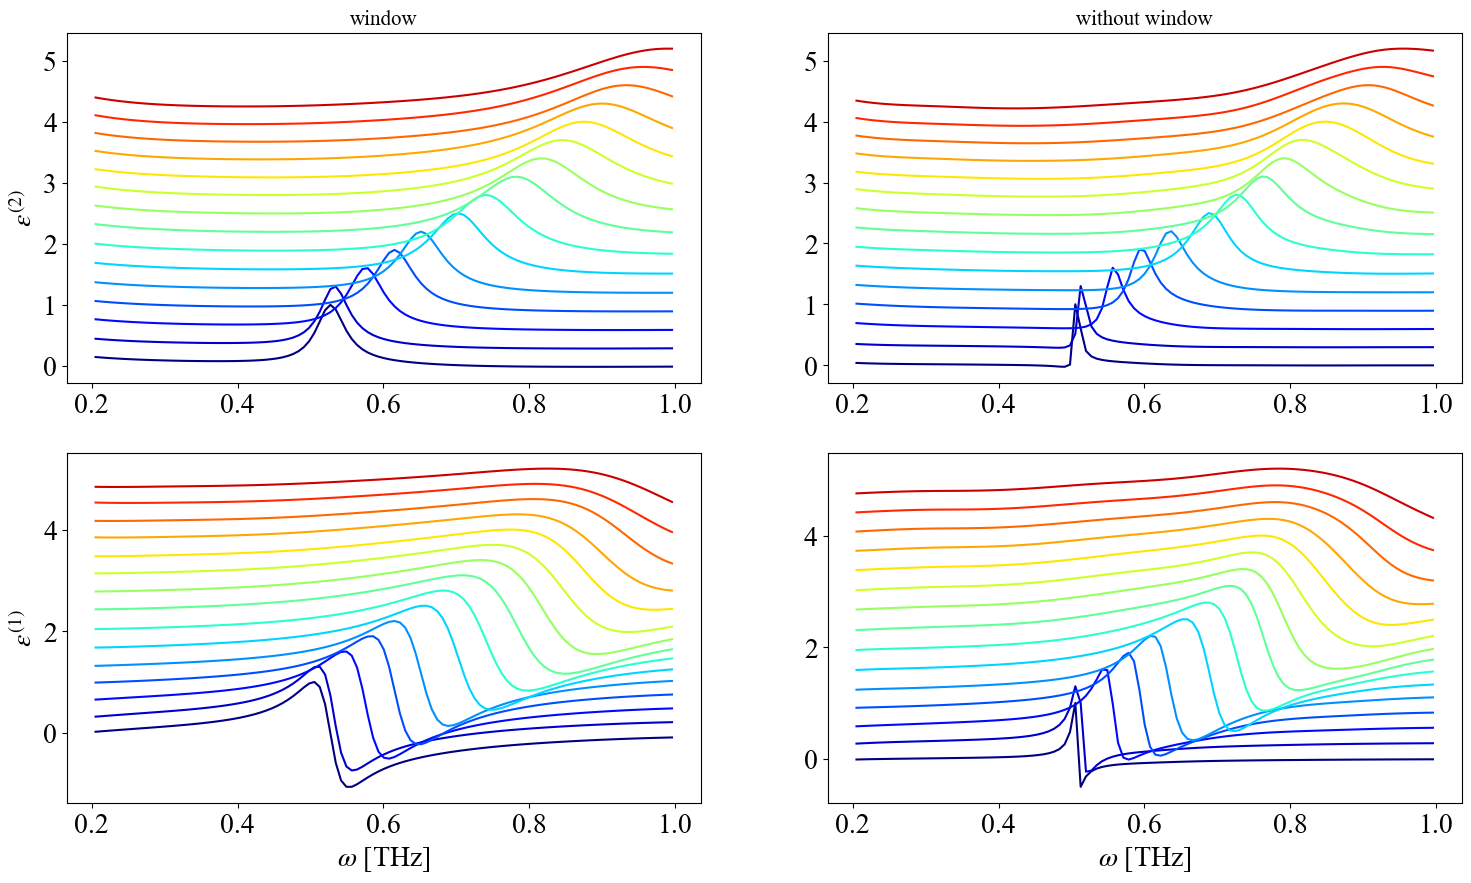

In [66]:
# Leer los archivos .dat
# f = plt.figure(figsize=(15,13))
permitividade_window = []
permitividade = []
temps = []
N = 2**12

fig = plt.figure(figsize=(18, 10))
for i,j in enumerate(archivos_ordenados_s[::-1]):


    path_signal = os.path.join(path_analisis,j)
    path_ref = os.path.join(path_analisis_ref ,archivos_ordenados_ref[0])
    temps.append(extraer_temperatura(path_signal))
    # params_window = ['gaussian', 46.78]
    params_window = ['barthann']
    x,y = getFilterdata(path_signal,nk1,nk0)
    x_ref,y_ref = getFilterdata(path_ref,nk2,nk0)
   
    phase, y_signal_ventaneada, y_substrate_padding, ventana = getSignalWindowed(path_signal,path_ref,nk0,nk1,nk2,params_window)
    # Datos substrate
    y_subs_ventana = pd.Series(y_substrate_padding*ventana)
    y_signal_ventaneada = pd.Series(y_signal_ventaneada*ventana)

    
    k = 15
    nu = sp.fft.fftfreq(N, 1/30)
        # Aplicar ventana de Hamming a la señal

    # Transformada de Fourier de las señales
    fft_y_signal_ventaneada =  FourierT2(y_signal_ventaneada,N)[1:len(nu)//k]
    fft_y_subs_ventaneada =  FourierT2(y_subs_ventana,N)[1:len(nu)//k]
    fft_y_signal= FourierT2(y,N)[1:len(nu)//k]
    fft_y_subs = FourierT2(y_ref,N)[1:len(nu)//k]


    # Filtrar las frecuencias
    nu = nu[1:len(nu)//k]
    xmin, xmax = 0.2, 1.0
    mask = (nu >= xmin) & (nu <= xmax)
    nu_filtradas = nu[mask]
    fft_y_signal_ventaneada = fft_y_signal_ventaneada[mask]
    fft_y_subs_ventaneada = fft_y_subs_ventaneada[mask]
    fft_y_signal = fft_y_signal[mask]
    fft_y_subs = fft_y_subs[mask]

    
    # phase = idx_max_signal-idx_max_substrate

    T_ventana = (fft_y_signal_ventaneada/fft_y_subs_ventaneada)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)*np.exp(1j*2*np.pi*nu_filtradas*phase*1/30)
    T = (fft_y_signal/fft_y_subs)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)
    n = 2.6
    ep_con = 1j*(1+n)*((1/T_ventana)-1)*c/(2*np.pi*nu_filtradas*d)-n
    ep_sin = 1j*(1+n)*((1/T)-1)*c/(2*np.pi*nu_filtradas*d)-n

    n = 2.6

    
    permitividade_window.append(ep_con)
    permitividade.append(ep_sin)


    plt.subplot(221)
    plt.plot(nu_filtradas, np.abs(fft_y_signal_ventaneada), label='FFT SIGNAL',color = colors[i])
    plt.ylabel('Absolute Value Fourier Transform',fontsize=15)
    plt.title('PbTe',fontsize=20)
    #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    #plt.legend()

    plt.subplot(222)
    plt.plot(nu_filtradas, np.abs(fft_y_subs_ventaneada), label='FFT SUBSTRATE',color = colors[i])
    plt.title('Substrate',fontsize=20)
    #plt.ylabel('Absolute Value Fourier Transform',fontsize=15)
    #plt.xlabel(r'$\nu$ [THz]',fontsize=15)
    # plt.legend()



    plt.subplot(223)
    plt.plot(nu_filtradas, np.imag(ep_sin)*1e-3,color = colors[i])
    
    #plt.yscale('log')
    plt.ylabel(r'$\epsilon^{(2)}\times 10^{-3}$',fontsize=20)
    plt.xlabel(r'$\omega$ [THz]',fontsize=20)
    # plt.legend()
# 

    plt.subplot(224)
    plt.plot(nu_filtradas, np.real(ep_sin)*1e-3, label='with window '+str(extraer_temperatura(archivos_ordenados_s[i]))+' K',color = colors[i])
    #plt.yscale('log')
    plt.ylabel(r'$\epsilon^{(1)}\times 10^{-3}$',fontsize=20)
    plt.xlabel(r'$\omega$ [THz]',fontsize=20)
    #plt.title(f'Delta sample real:{round(delta_ls[sample],4)}, Delta sample correg: {round(delta_ls_corr,5)}')
    #plt.legend()


fig, (ax1, ax2) = plt.subplots(2,2,figsize=(18, 10))
offset = 0.3  # Desplazamiento vertical entre las curvas
cont = 0
for i in range(1,len(permitividade_window),1):
    ep_window = permitividade_window[-i]
    ep = permitividade[-i]
    ax1[0].plot(nu_filtradas, np.imag(ep_window)/max(np.imag(ep_window)) + cont * offset, color=colors[-i], label=f'T: {round(temps[-i],3)} K')
    ax1[0].set_ylabel(r'$\epsilon^{(2)}$',fontsize=20)
    ax1[0].set_title('window')

    ax1[1].plot(nu_filtradas, np.imag(ep)/max(np.imag(ep)) + cont * offset, color=colors[-i], label=f'T: {round(temps[-i],3)} K')
    ax1[1].set_title('without window')
    #ax2.set_ylabel(r'$\epsilon^{(2)}$',fontsize=20)
    #ax1.set_title('Sample: '+sample)
    ax2[0].plot(nu_filtradas, np.real(ep_window)/max(np.real(ep_window)) + cont * offset, color=colors[-i], label=f'T: {round(temps[-i],3)} K')
    ax2[0].set_ylabel(r'$\epsilon^{(1)}$',fontsize=20)
    ax2[0].set_xlabel(r'$\omega$ [THz]',fontsize=20)
    #ax2.set_title('Sample: '+sample)
    ax2[1].plot(nu_filtradas, np.real(ep)/max(np.real(ep)) + cont * offset, color=colors[-i], label=f'T: {round(temps[-i],3)} K')
    ax2[1].set_xlabel(r'$\omega$ [THz]',fontsize=20)
   # plt.legend(loc='upper right')
    cont+=1

In [57]:
Temp = [extraer_temperatura(archivos_ordenados_s[i]) for i in range(len(archivos_ordenados_s))]

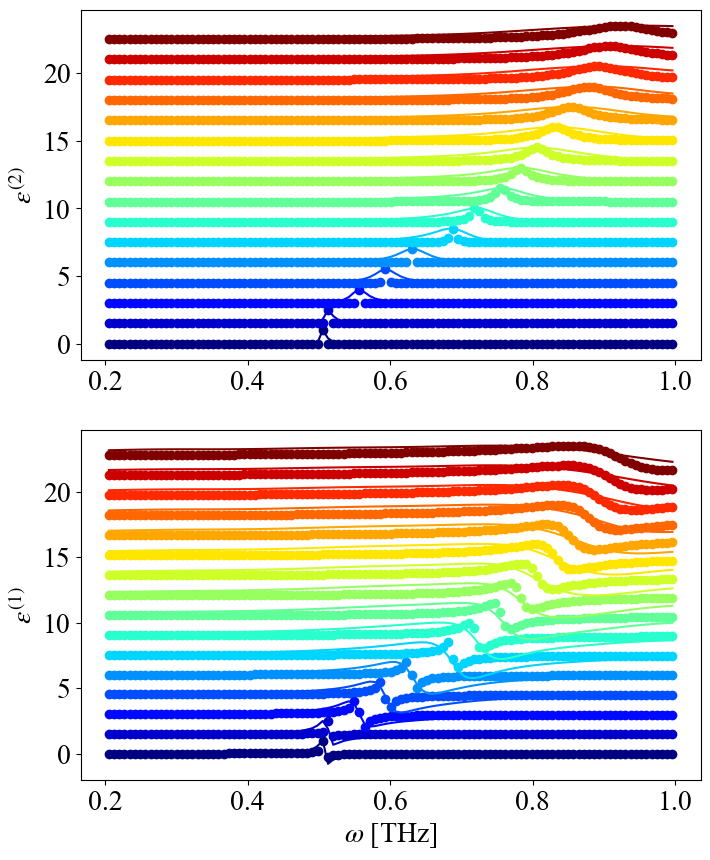

In [58]:
ep_inf,ep_s,nu_to,Gamma,nu_p,gamma = [],[],[],[],[],[]
#ep_inf,ep_s,nu_to,Gamma,nu_p,gamma = [],[],[],[]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8, 10))

cont = 0
offset = 1.5

for permit in permitividade[::-1]: ##

    yNoisy = permit
    yReal = np.real(yNoisy)
    yImag = np.imag(yNoisy)
    params = fit_complex(nu_filtradas,yNoisy,[])
    ep_inf.append(params[0])
    ep_s.append(params[1])
    nu_to.append(params[2])
    Gamma.append(params[3])
    # nu_p.append(params[4])
    # gamma.append(params[5])

    yFit = epsilon(nu_filtradas, *params)

    ax1.plot(nu_filtradas, np.imag(permit )/max(np.imag(permit )) + cont * offset, color=colors[-cont-1], label=f'T: {round(temps[-i],3)} K')
    ax1.plot(nu_filtradas, np.imag(yFit)/max(np.imag(yFit)) + cont * offset,'o',color=colors[-cont-1], label=f'T: {round(temps[-i],3)} K')
    #ax1.set_xlabel(r'$\nu$ [THz]',fontsize=15)
    ax1.set_ylabel(r'$\epsilon^{(2)}$',fontsize=20)
    #ax1.set_title('Sample: '+sample)
    ax2.plot(nu_filtradas, np.real(permit)/max(np.real(permit)) + cont * offset, color=colors[-cont-1], label=f'T: {round(temps[-i],3)} K')
    ax2.plot(nu_filtradas, np.real(yFit)/max(np.real(yFit)) + cont * offset,'o',color=colors[-cont-1], label=f'T: {round(temps[-i],3)} K')
    ax2.set_ylabel(r'$\epsilon^{(1)}$',fontsize=20)
    ax2.set_xlabel(r'$\omega$ [THz]',fontsize=20)
    #ax2.set_title('Sample: '+sample)
    # plt.legend(loc='upper right')

    cont+=1

nu_to_window = []
for permit in permitividade_window[::-1]: ##

    yNoisy = permit
    yReal = np.real(yNoisy)
    yImag = np.imag(yNoisy)
    params = fit_complex(nu_filtradas,yNoisy,[])
    nu_to_window.append(params[2])


temp_parameters, pcovBoth = curve_fit(T_crit,Temp,nu_to, maxfev=5000)
temp_parameters_window, pcovBoth = curve_fit(T_crit,Temp,nu_to_window, maxfev=5000)

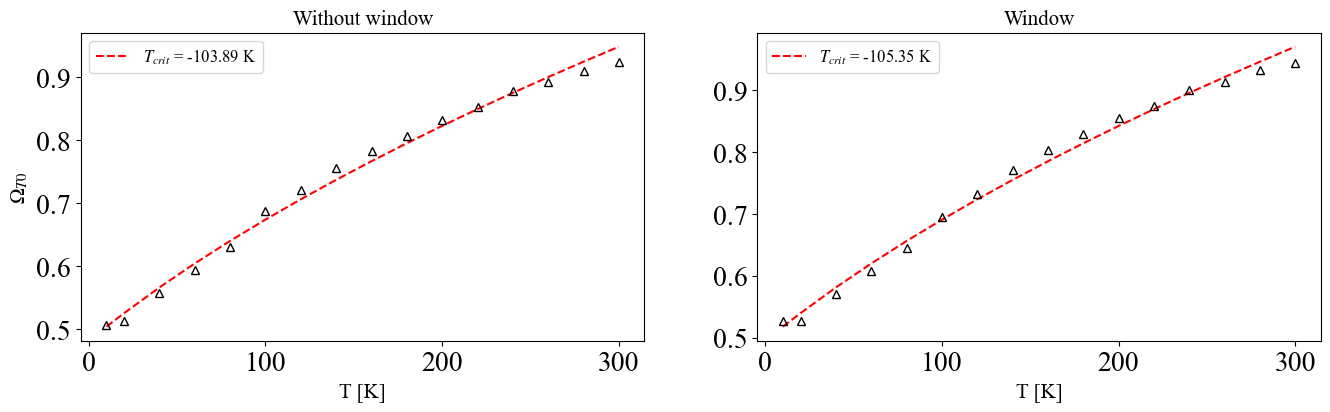

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))  # Tamaño ajustado
ax[0].plot(Temp,T_crit(Temp,*temp_parameters),'--r',label =r'$T_{crit}$ = ' +str(round(temp_parameters[1],2))+' K' )
ax[0].plot(Temp, nu_to, marker='^', color='black', linestyle='none', markerfacecolor='none')
    #ax.set_title(titles[i])
ax[0].set_xlabel('T [K]')
ax[0].set_ylabel(r'$\Omega_{T0}$ ')
ax[0].set_title(r'Without window')
# ax.set_ylabel(titles[i], fontweight='bold',fontsize=15)
ax[0].legend()


ax[1].plot(Temp,T_crit(Temp,*temp_parameters_window),'--r',label =r'$T_{crit}$ = ' +str(round(temp_parameters_window[1],2))+' K' )
ax[1].plot(Temp, nu_to_window, marker='^', color='black', linestyle='none', markerfacecolor='none')
    #ax.set_title(titles[i])
ax[1].set_xlabel('T [K]')
ax[1].set_title(r'Window')
#ax[0].set_ylabel(r'$\Omega_{T0}$ ')

# ax.set_ylabel(titles[i], fontweight='bold',fontsize=15)
ax[1].legend()

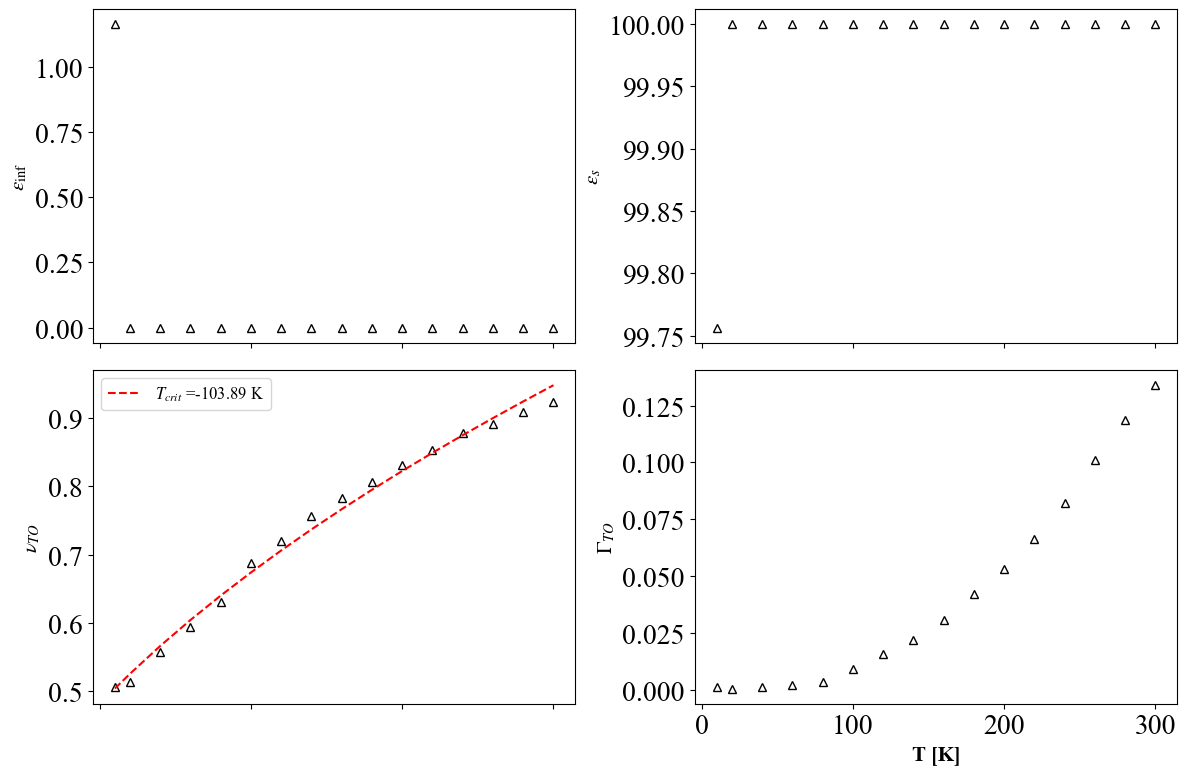

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Tamaño ajustado

# Listas de los datos y títulos
y_data = [ep_inf, ep_s, nu_to, Gamma]
titles = ['$\epsilon_{\inf}$', '$\epsilon_{s}$', r'$\nu_{TO}$', '$\Gamma_{TO}$', r'$\nu_p$', '$\gamma$']

# Iterar sobre los ejes y dibujar los gráficos
for i, ax in enumerate(axes.flat):
    #ax.plot(Temp[::-1], y_data[i], marker='^', color='black')
    ax.plot(Temp, y_data[i], marker='^', color='black', linestyle='none', markerfacecolor='none')
    #ax.set_title(titles[i])
    #ax.set_xlabel('x')
    ax.set_ylabel(titles[i], fontweight='bold',fontsize=15)

    if i==2:
        ax.plot(Temp,T_crit(Temp,*temp_parameters),'--r',label =r'$T_{crit}$ =' +str(round(temp_parameters[1],2))+' K' )
        ax.legend()
    if i <3:
        ax.set_xticklabels([])
    if i >= 3:  # Fila 2
        ax.set_xlabel('T [K]', fontweight='bold',fontsize=15)
    #ax.set_ylabel(titles[i])
    #ax.grid(True)  # Agregar grillas para mejor visualización

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()


Text(0.5, 0, '$\\omega$ [THz]')

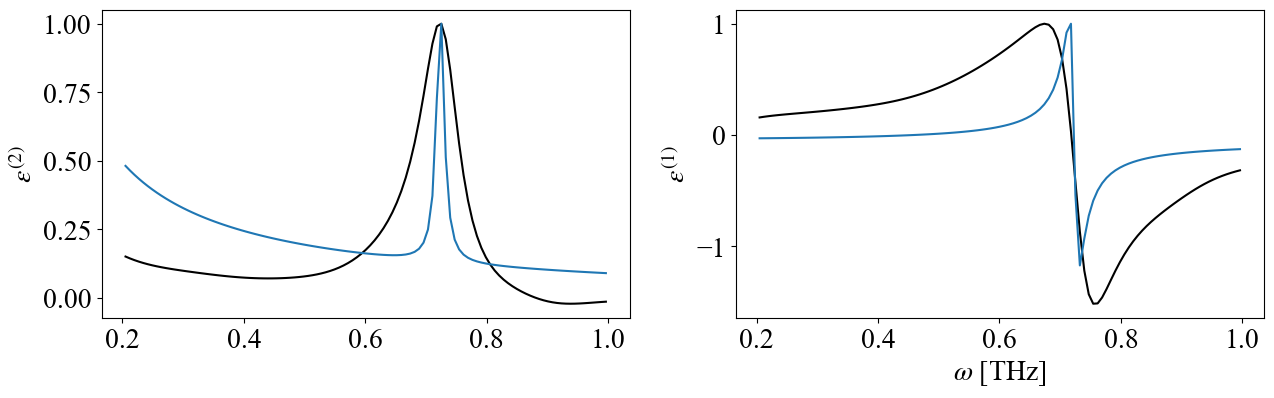

In [15]:
l = -10
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 4))
ex1 = permitividade[::-1][l]
params = [ep_inf[l],ep_s[l],nu_to[l],Gamma[l],nu_p[l],gamma[l] ]
yFit = epsilon_drude(nu_filtradas, *params)

ax1.plot(nu_filtradas, np.imag(ex1)/max(np.imag(ex1)),'k' )
ax1.plot(nu_filtradas, np.imag(yFit)/max(np.imag(yFit)))
#ax1.set_xlabel(r'$\nu$ [THz]',fontsize=15)
ax1.set_ylabel(r'$\epsilon^{(2)}$',fontsize=20)
#ax1.set_title('Sample: '+sample)
ax2.plot(nu_filtradas, np.real(ex1)/max(np.real(ex1)),'k')
ax2.plot(nu_filtradas, np.real(yFit)/max(np.real(yFit)))
ax2.set_ylabel(r'$\epsilon^{(1)}$',fontsize=20)
ax2.set_xlabel(r'$\omega$ [THz]',fontsize=20)
#ax2.set_title('Sample: '+sample)

In [ ]:
def E_trans(nu,E_ref,d,n,deltal,epsil):

    return E_ref*np.exp(-2*np.pi*1j*(1-n)*deltal/c)*(-1j*(epsil+n)/(1+n)*2*np.pi*nu*d/c+1)**-1

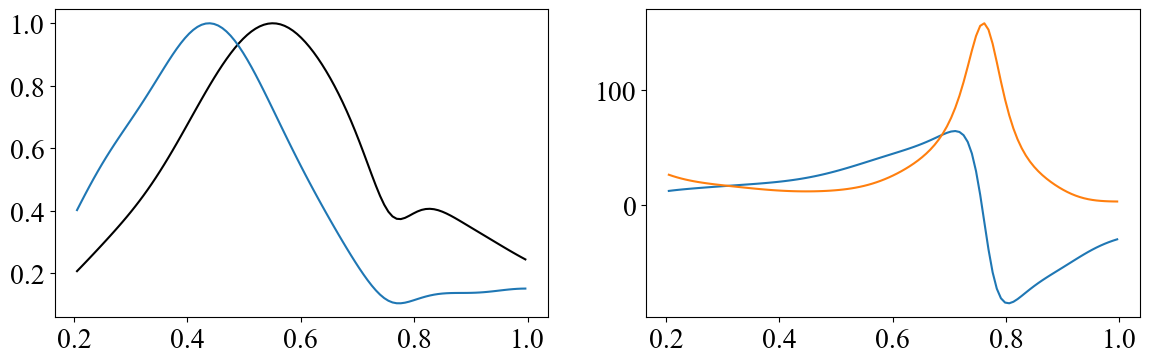

In [ ]:
l = 7
path_signal = os.path.join(path_analisis,archivos_ordenados_s[l]) 
x,y = getFilterdata(path_signal,nk1,nk0)
ex1 = permitivadade[::-1][l]
permitivadade[::-1]
nu = sp.fft.fftfreq(N, 1/30)
k = 15  
x_ref,y_ref = getFilterdata(path_ref,nk2,nk0)
fft_y_subs = FourierT(y_ref,N)[1:len(nu)//k]
fft_y_signal= FourierT(y,N)[1:len(nu)//k]
nu = nu[1:len(nu)//k]
xmin, xmax = 0.2, 1.0
mask = (nu >= xmin) & (nu <= xmax)
nu_filtradas = nu[mask]
fft_y_subs = fft_y_subs[mask]
fft_y_signal= fft_y_signal[mask]
fft_theor = E_trans(nu_filtradas,fft_y_subs,d,n,delta_ls_corr,ex1)

f = plt.figure(figsize=(14,4))

plt.subplot(121)
plt.plot(nu_filtradas,np.abs(fft_theor)/max(np.abs(fft_theor)),'k',label='Theoretical')
plt.plot(nu_filtradas,np.abs(fft_y_signal)/max(np.abs(fft_y_signal)),label='Experimental')


T = (fft_y_signal/fft_y_subs)*np.exp(2*np.pi*1j*nu_filtradas/c*(1-2.6)*delta_ls_corr)
n = 2.6
ep_sin = 1j*(1+n)*((1/T)-1)*c/(2*np.pi*nu_filtradas*delta_ls_corr)-n

plt.subplot(122)
plt.plot(nu_filtradas,np.real(ep_sin))
plt.plot(nu_filtradas,np.imag(ep_sin))

In [5]:
ro = 2.820
rho = 0.321

1/(2*ro)*(1/(ro*rho)**2-6/ro**4)/(1/(ro*rho**2)-2/ro**3)

0.05952871268837114

c:\Users\usuario_trabajo\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\usuario_trabajo\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


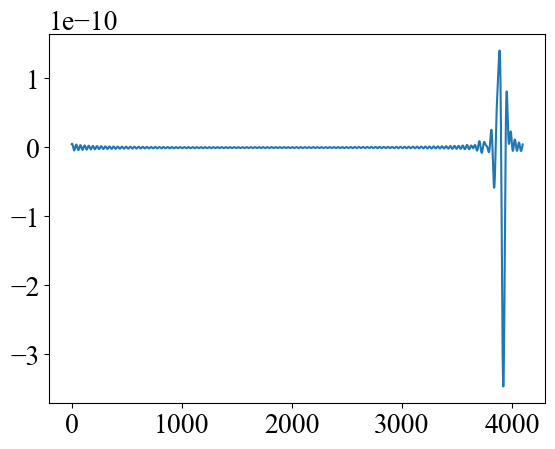

In [ ]:
t.plot(FourierI(fft_theor,N))

# Example paper windows

In [26]:
# Define the rectangular function
def rect(t, width=1, center=0):
    """Returns a rectangular function that is 1 for |t - center| < width/2, else 0."""
    return np.where(np.abs(t - center) <= width / 2, 1, 0)



In [ ]:
def anim2(center,width,A0,omega,Lr,Ll):
    
    
    # N = 2**(int(n))
    N = 2**12
    T = np.linspace(Ll,Lr,N)

        # Define the time axis (x-axis)
    # t = np.linspace(-5, 5, 1000)  # 1000 points between -5 and 5

    # Parameters of the rectangular function
    width = width   # Width of the rectangle
    center = center  # Center of the rectangle

    # Compute the rectangular function
    y_rect = rect(T, width, center)
    osc = A0*np.sin(omega*np.pi*T/(center-width/2))

    y2 = y_rect*osc
    Tright = T+abs(Ll-Lr)
    Tleft = T-abs(Ll-Lr)
    dt = T[1]-T[0]
    y = np.exp(-T**2)
    y_osc= y2+y
    f = plt.figure(figsize=(14,7))

    plt.subplot(121)
    #plt.plot(T,y,'k',label='Signal')
    plt.plot(T, y_osc)
    #plt.plot(Tright,y_osc,'r',label='Periodic continuation right')
    plt.xlabel('Time')
    #plt.plot(Tleft,y_osc,'b',label='Periodic continuation left')
    plt.legend(loc='upper right')

    plt.subplot(122)
    nu = sp.fft.fftfreq(N,dt)
   
    fy = FourierT(y,N)
    fy2 = FourierT(y,2**12)
    fy3 = FourierT(y_osc,2**12)
    nu2 = sp.fft.fftfreq(2**12,dt)
    fourier_t = 1/np.sqrt(2)*np.exp(-(2*np.pi*nu)**2/4)
    #plt.plot(nu2,np.abs(fy3)/max(fy3), 'k',label='Fourier transform signal with oscilations')
    plt.plot(nu2,fy3, '--ko',label='Fourier transform signal with oscilations')
    #plt.plot(nu,np.abs(fy)/max(np.abs(fy)),'o',label=f'Fourier transform signal without oscilations')
    plt.xlabel(r'$\nu$',fontsize=14)
    #plt.yscale('log')
    plt.legend(loc='upper right')

    
    plt.xlim(-2,2)
    # plt.legend()
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        center= widgets.FloatSlider(min=0,max=14,value=12,step=1,**opc),
        width= widgets.FloatSlider(min=0,max=40,value=12,step=1,**opc),
        A0= widgets.FloatSlider(min=0,max=1,value=1,step=0.001,**opc),
        omega= widgets.FloatSlider(min=0,max=100,value=1,step=0.001,**opc),
        Lr= widgets.FloatSlider(min=0,max=14,value=12,step=1,**opc),
        Ll= widgets.FloatSlider(min=-14,max=20,value=-3,step=1,**opc)
        

        )



interactive(children=(FloatSlider(value=12.0, continuous_update=False, description='center', max=14.0, readout…

<function __main__.anim2(center, width, A0, omega, Lr, Ll)>

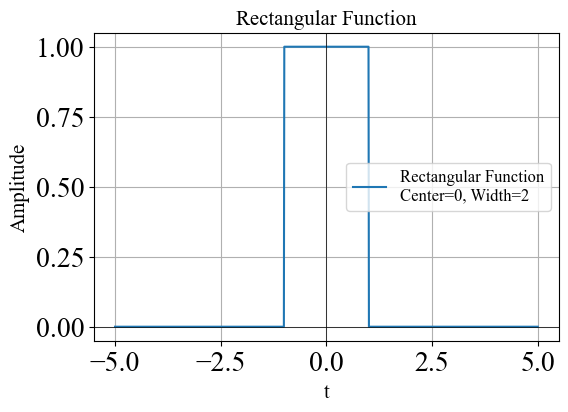

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the rectangular function
def rect(t, width=1, center=0):
    """Returns a rectangular function that is 1 for |t - center| < width/2, else 0."""
    return np.where(np.abs(t - center) <= width / 2, 1, 0)

# Define the time axis (x-axis)
t = np.linspace(-5, 5, 1000)  # 1000 points between -5 and 5

# Parameters of the rectangular function
width = 2   # Width of the rectangle
center = 0  # Center of the rectangle

# Compute the rectangular function
y = rect(t, width, center)

# Plot the function
plt.figure(figsize=(6, 4))
plt.plot(t, y, label=f'Rectangular Function\nCenter={center}, Width={width}')
plt.title('Rectangular Function')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()


# Model pulse through absortive media

Consider a Gaussian pulse initially propagated in vacuum

$$f(t) = E_0 \text{exp}\left(-at^2\right)\text{exp}\left(i\omega_0 t\right)$$

In order for the measured field fit completely with a permitivity model, we expect that





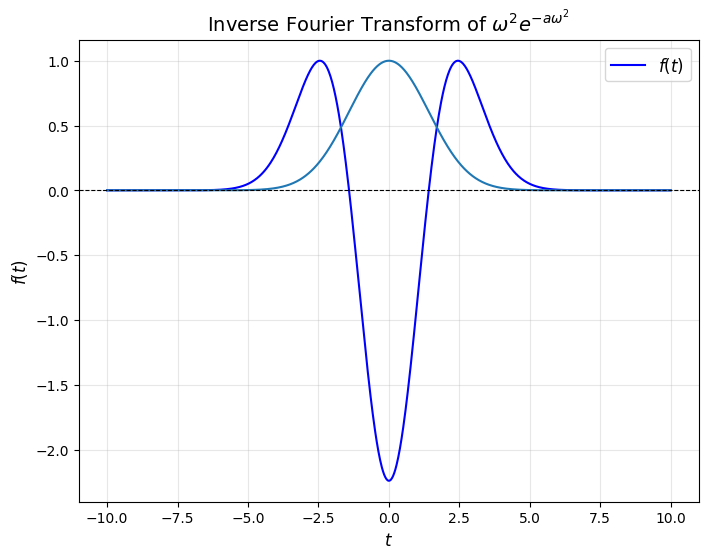

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
a = 1  # parameter in the Gaussian (a > 0)
t = np.linspace(-10, 10, 1000)  # time domain

# Define the inverse Fourier transform result
prefactor = 1 / (2 * np.pi) * np.sqrt(np.pi / a)
exponent = -t**2 / (4 * a)
gaussian = prefactor * (t**2 / (4 * a**2) - 1 / (2 * a)) * np.exp(exponent)

# Plot the result
plt.figure(figsize=(8, 6))
plt.plot(t, gaussian/max(gaussian), label=r"$f(t)$", color="blue")
plt.plot(t,np.exp(exponent)/max(np.exp(exponent)))
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title(r"Inverse Fourier Transform of $\omega^2 e^{-a \omega^2}$", fontsize=14)
plt.xlabel(r"$t$", fontsize=12)
plt.ylabel(r"$f(t)$", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()


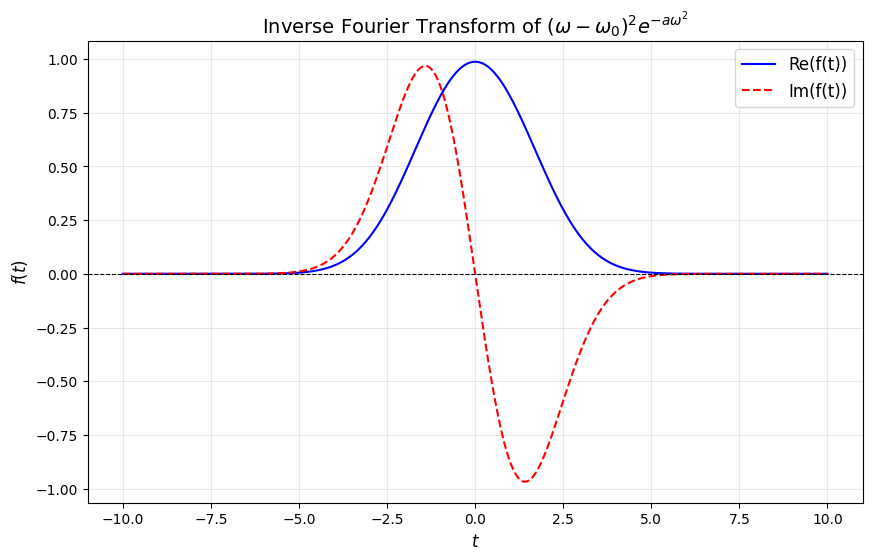

In [ ]:
# Define constants
omega_0 = 2  # Frequency shift
a = 1  # Gaussian parameter
t = np.linspace(-10, 10, 1000)  # Time domain

# Define the inverse Fourier transform result
prefactor = 1 / (2 * np.pi) * np.sqrt(np.pi / a)
exponent = -t**2 / (4 * a)

# Terms in the result
term1 = (t**2 / (4 * a**2) - 1 / (2 * a))  # From ω^2 term
term2 = -2j * omega_0 * t / (a**(3/2))  # From ω term
term3 = omega_0**2 / np.sqrt(a)  # Constant term



# Combine terms
gaussian_shifted = prefactor * (term1 + term2 + term3) * np.exp(exponent)

# Plot the result (real and imaginary parts)
plt.figure(figsize=(10, 6))
plt.plot(t, gaussian_shifted.real, label="Re(f(t))", color="blue")
plt.plot(t, gaussian_shifted.imag, label="Im(f(t))", color="red", linestyle="--")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title(r"Inverse Fourier Transform of $(\omega - \omega_0)^2 e^{-a \omega^2}$", fontsize=14)
plt.xlabel(r"$t$", fontsize=12)
plt.ylabel(r"$f(t)$", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()


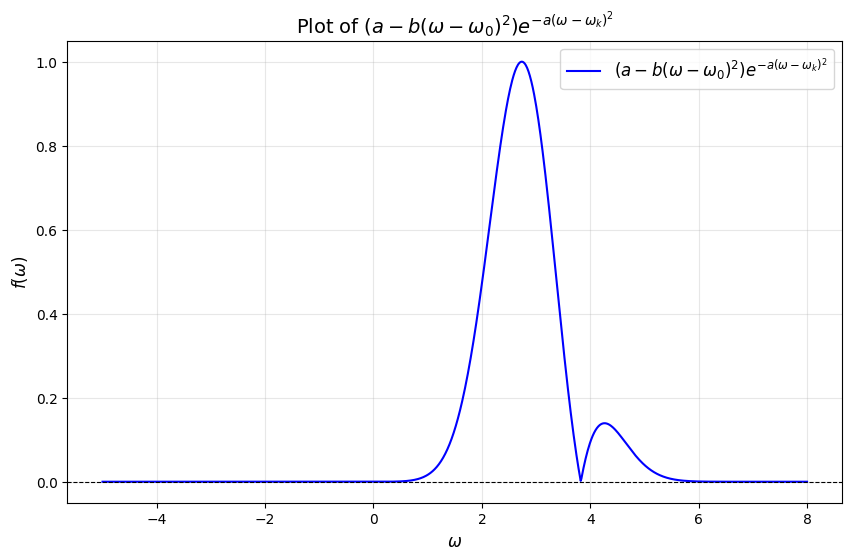

In [ ]:
# Re-import necessary libraries after reset
import numpy as np
import matplotlib.pyplot as plt

# Define constants
a = 1.0  # Gaussian parameter
b = 0.3  # Quadratic coefficient
omega_0 = 2.0  # Frequency center for the quadratic term
omega_k = 3.0  # Frequency center for the Gaussian

# Define frequency range
omega = np.linspace(-5, 8, 1000)

# Compute the function
quadratic_term = a - b * (omega - omega_0)**2
gaussian_term = np.exp(-a * (omega - omega_k)**2)
function = quadratic_term * gaussian_term

# Plot the result
plt.figure(figsize=(10, 6))
#plt.plot(omega,quadratic_term/max(quadratic_term))
plt.plot(omega, abs(function)/max(abs(function)), color="blue", label=r"$(a - b(\omega - \omega_0)^2)e^{-a(\omega - \omega_k)^2}$")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title(r"Plot of $(a - b(\omega - \omega_0)^2)e^{-a(\omega - \omega_k)^2}$", fontsize=14)
plt.xlabel(r"$\omega$", fontsize=12)
plt.ylabel(r"$f(\omega)$", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()



In [ ]:
# Define constants

def anim2(omega_0,omega_k,a):
    
    
        # omega_0 = 3  # Frequency shift of the quadratic term
        # omega_k = 3  # Frequency shift of the Gaussian center
        # a = 1  # Gaussian parameter
        t = np.linspace(-10, 10, 1000)  # Time domain

        # Define the inverse Fourier transform result
        prefactor = 1 / (2 * np.pi) * np.sqrt(np.pi / a)
        exponent = -t**2 / (4 * a)

        # Compute terms with shifted frequency
        delta = omega_k - omega_0
        term0 = 1
        term1 = (t**2 / (4 * a**2) - 1 / (2 * a))  # From ξ^2 term
        term2 = -2j * delta * t / (a**(3/2))  # From 2ξ(ω_k - ω_0) term
        term3 = delta**2 / np.sqrt(a)  # Constant term
        gaussiann =  np.exp(exponent) * np.exp(1j * omega_k * t)*term0

        # Combine terms
        gaussian_shifted_full = prefactor * (term0+term1 + term2 + term3) * np.exp(exponent) * np.exp(1j * omega_k * t)

        # Plot the result (real and imaginary parts)
        plt.figure(figsize=(10, 6))
        plt.plot(t, gaussian_shifted_full.real/max(gaussian_shifted_full.real), label="Re(f(t))", color="blue")
        plt.plot(t, gaussian_shifted_full.imag/max(gaussian_shifted_full.imag), label="Im(f(t))", color="red", linestyle="--")
        plt.plot(t, gaussiann/max(gaussiann))
        plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
        plt.title(r"Inverse Fourier Transform of $(\omega - \omega_0)^2 e^{-a (\omega - \omega_k)^2}$", fontsize=14)
        plt.xlabel(r"$t$", fontsize=12)
        plt.ylabel(r"$f(t)$", fontsize=12)
        plt.grid(alpha=0.3)
        plt.legend(fontsize=12)
        plt.show()


opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        omega_0= widgets.FloatSlider(min=0,max=14,value=1,step=1,**opc),
        omega_k= widgets.FloatSlider(min=0,max=40,value=1,step=1,**opc),
        a= widgets.FloatSlider(min=0,max=1,value=1,step=0.001,**opc)

        )



interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='omega_0', max=14.0, readout…

<function __main__.anim2(omega_0, omega_k, a)>

# Windows in THz time domain spectroscopy

Usually, a THz time domain experiment consist in measure both, a reference and transmited electric field through an especific material. Both recorded signals are used to measure some relevant parameters of the materials through a model for tiny films,

$$\epsilon_{d,T}(\nu) = i(1 + n) \left[ \frac{1}{\mathcal{T}_{d,T}(\nu)} - 1 \right] \frac{c}{2 \pi \nu d} - n = \epsilon_{\infty} + \frac{(\epsilon_s - \epsilon_{\infty})\nu_{\text{TO}}^2}{\nu_{\text{TO}}^2 - \nu^2 - i \nu \Gamma_{\text{TO}}} - \frac{\nu_p^2}{\nu^2 + i \nu \gamma}$$

This expression relates the measured signals $\mathcal{T}_{d,T}(\nu)=\tilde{E}_d(\nu)/\tilde{E}_{ref}(\nu)\times e^{2\pi i \nu (1-n)\Delta L}$  with material parameters $\epsilon_{\infty}, \epsilon_s, \nu_{\text{TO}}$,... 

When we perform an experiment, we sample the signals in a finite temporal interval. For the FFT, both the time domain and the frequency domain are circular topologies, so the two endpoints of the time waveform are interpreted as though they were connected together, as a consequence discontinuities at the boundaries may appear and can contribute with unwanted frequencies (see image)

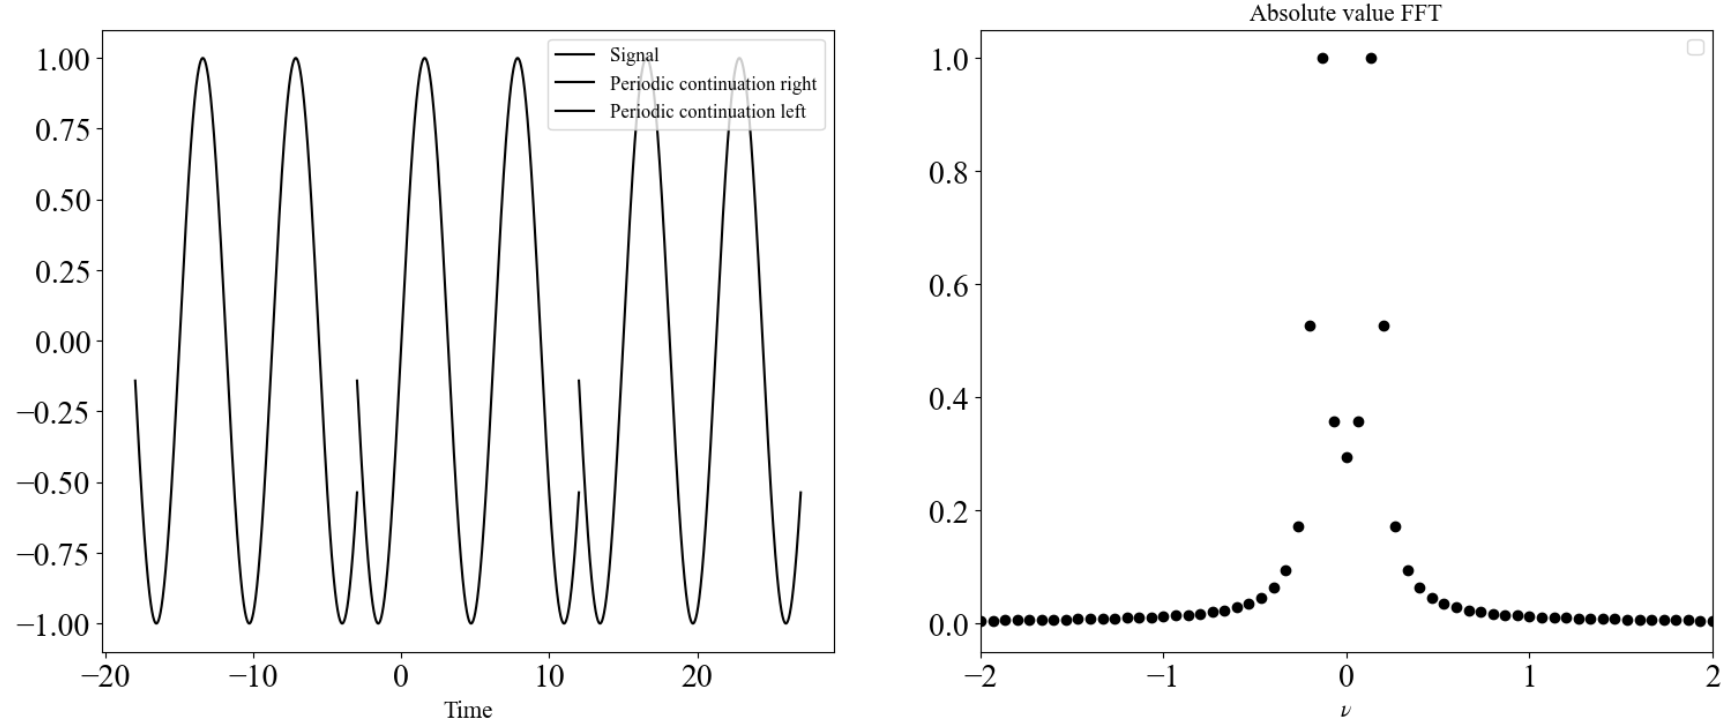

In general, there is a vast literature for signal processing focus in use of windowing to reduce Leakege. However, for each specific situation it must be choosen an appropiate window that smoothly reduce the discontinuities but also keep relevant information of the recorded signals.  Particularly, in the THz domain there are some papers that discussed for commonly situations in experiments, how to process signals in order to improve results. Also, there is a paper which focus on the use of different windows and metrics for quantify which window is the best, however, the conclusion depend on the very particular conditions of the experiment.

Un analisis más riguroso del efecto de las ventanas en la señal de interes consiste en intentar hallar una expresión analitica para la propagación de un pulso en un medio e intentar predecir con que tipo de ventana, los efectos relevantes del pulso se preservan, mientras se eliminan aquellos correspondientes al Leakege. Por otro lado, un estudio de este tipo permitiría dar un estimativo respecto a cuando es necesario aplicar ventanas en situaciones particulares.

# Simplified model.

In order to gain some insight of the idea that we want to propose, consider a simplified case, which is the propagation of a gaussian pulse, through a material and there is measured. In that case the transmitance function is given by,

$$\tilde{E}_{ref}(\omega) = \sqrt{\frac{\pi}{a_o}}\text{exp}\left[-\left(\omega-\omega_0\right)^{2}/4a_0 \right] \times \sum^{P}_{k=1} \left( A_{n}-\frac{B_{n}}{1-\left( \frac{\omega-\omega_k}{\gamma_k}\right)^2 }\right) $$

Therefore, keeping the two first terms of the Lorentian function,


$$E(t) = \left[\sum^{P}_{k=1} (A_{n}-B_n) \right] \times \sqrt{\frac{\pi}{a_o}}\text{exp}\left[-a_o t^{2} \right]\text{exp}\left[-i\omega_0 t \right]-\frac{1}{2\pi}\sum^{P}_{k=1}B_k  e^{-t \left( a_0 t + i \omega k \right)} 
\left( -4 a_0^2 t^2 + a_0 \left( 2 - 4 i t (\omega_0 - \omega_k) \right) 
+ (\omega_0 - \omega_k)^2 \right)$$ 
$$\approx \text{exp}\left[-a_o t^{2} \right]\text{exp}\left[-i\omega_0 t \right] \times \left\{ (A_{1}-B_1) -\frac{1}{2\pi}  
\left( -4 a_0^2 t^2 + a_0 \left( 2 - 4 i t (\omega_0 - \omega_k) \right) + (\omega_0 - \omega_k)^2 \right)  \right\}$$








# Propagation of a pulse trough an absorptive media

Suppose that an initial gaussian pulse with spectrum,

$$\tilde{E}(\omega) = \sqrt{\frac{\pi}{a_o}}\text{exp}\left[-\left(\omega-\omega_0\right)^{2}/4a_0 \right] $$

If the spectrum progates through a dispersive and disipative media, the different components of the initial sprectrum will suffer different effects, which in the time domain can cause that the pulse itself suffer delays in different times. We want to find an analytical expresion to the final pulse which propagates in a media with permitivity,

$$\epsilon(\nu) = \epsilon_{\infty} + \frac{(\epsilon_s - \epsilon_{\infty})\nu_{\text{TO}}^2}{\nu_{\text{TO}}^2 - \nu^2 - i \nu \Gamma_{\text{TO}}} - \frac{\nu_p^2}{\nu^2 + i \nu \gamma}$$

Where,

$$\text{Re}(\epsilon(\nu)) = \epsilon_{\infty} + \frac{(\epsilon_s - \epsilon_{\infty}) \nu_{\text{TO}}^2 (\nu_{\text{TO}}^2 - \nu^2)}{(\nu_{\text{TO}}^2 - \nu^2)^2 + (\nu \Gamma_{\text{TO}})^2} - \frac{\nu_p^2 \nu^2}{\nu^4 + (\nu \gamma)^2}$$

and,

$$\text{Im}(\epsilon(\nu)) = \frac{(\epsilon_s - \epsilon_{\infty}) \nu_{\text{TO}}^2 (\nu \Gamma_{\text{TO}})}{(\nu_{\text{TO}}^2 - \nu^2)^2 + (\nu \Gamma_{\text{TO}})^2} - \frac{\nu_p^2 \nu \gamma}{\nu^4 + (\nu \gamma)^2}$$

There, if the spectrum does not suffer any other effect than the substrate and the film, the measure will be

$$\tilde{E}_d = i \frac{\tilde{E}_{ref}(\nu)}{\epsilon(\nu)+n}\frac{c}{2\pi \nu d}\times e^{-2\pi i \nu (1-n)\Delta L} $$

In order to find an analitycal expression, we exand at first order the denominator,
$$\tilde{E}_d =  i \tilde{E}_{ref}(\nu)
\frac{\frac{c}{2 n\pi \nu d}}{\epsilon(\nu)/n+1} 
\times e^{-2 \pi i \nu (1-n) \Delta L}\approx i \tilde{E}_{ref}(\nu) 
\frac{c}{2 n\pi \nu d}
\times e^{-2 \pi i \nu (1-n) \Delta L} \times \left[ {1-\epsilon(\nu)/n} \right]$$

Thefore, the inverse fourier transform,


$$E_d(t) $$




In [13]:
# Define symbols
nu = sp.symbols('nu', real=True)
epsilon_inf, epsilon_s, nu_TO, Gamma_TO, nu_p, gamma = sp.symbols(
    'epsilon_inf epsilon_s nu_TO Gamma_TO nu_p gamma', real=True
)

# Define the function epsilon(nu)
epsilon = (
    epsilon_inf +
    ((epsilon_s - epsilon_inf) * nu_TO**2) / (nu_TO**2 - nu**2 - 1j * nu * Gamma_TO) -
    (nu_p**2) / (nu**2 + 1j * nu * gamma)
)

# Taylor expansion around nu = nu_TO
taylor_expansion = sp.series(epsilon, nu, nu_TO, 3)

# Substitute numerical values for the parameters
params = {
    epsilon_inf: 6.1,
    epsilon_s: 9,
    nu_TO: 6.7,
    Gamma_TO: 2.2,
    nu_p: 0,
    gamma: 0.05
}
taylor_expansion_num = taylor_expansion.subs(params)


<Figure size 1000x600 with 0 Axes>

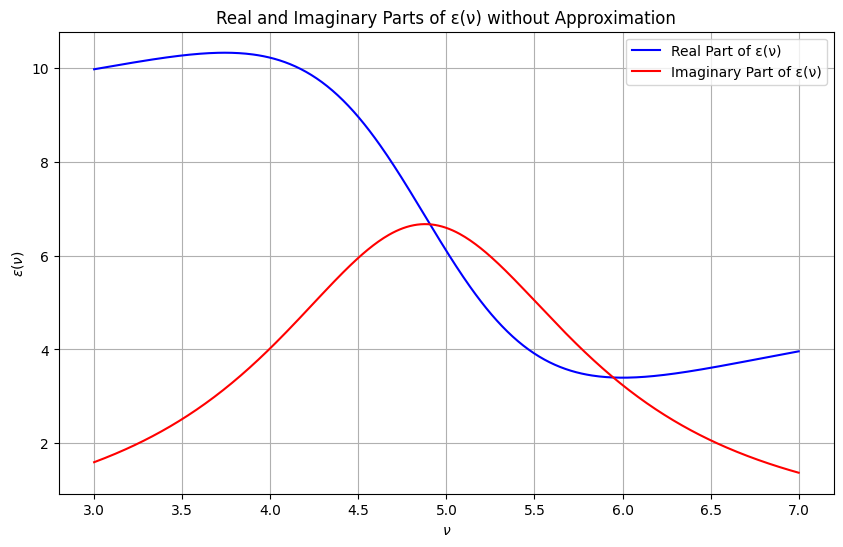

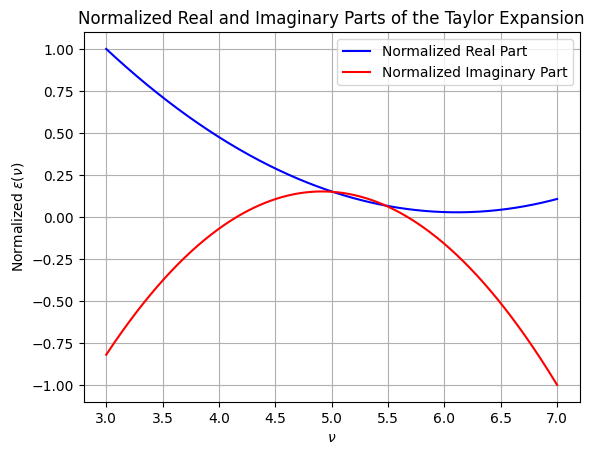

In [21]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# Define symbols
nu = sp.symbols('nu', real=True)
epsilon_inf, epsilon_s, nu_TO, Gamma_TO, nu_p, gamma = sp.symbols(
    'epsilon_inf epsilon_s nu_TO Gamma_TO nu_p gamma', real=True
)

# Define the function epsilon(nu)
epsilon = (
    epsilon_inf +
    ((epsilon_s - epsilon_inf) * nu_TO**2) / (nu_TO**2 - nu**2 - 1j * nu * Gamma_TO) -
    (nu_p**2) / (nu**2 + 1j * nu * gamma)
)

# Taylor expansion around nu = nu_TO
taylor_expansion = sp.series(epsilon, nu, nu_TO, 3).removeO()

# Substitute numerical values for the parameters
params = {
    epsilon_inf: 6.1,
    epsilon_s: 9,
    nu_TO: 5,
    Gamma_TO: 2.2,
    nu_p: 0,
    gamma: 0.05
}
taylor_expansion_num = taylor_expansion.subs(params)

# Convert the symbolic Taylor expansion to a numerical function
taylor_expansion_func = sp.lambdify(nu, taylor_expansion_num, 'numpy')

# Define the range of nu around nu_TO
nu_vals = np.linspace(params[nu_TO] - 3, params[nu_TO] + 3, 400)

# Compute the real and imaginary parts of the Taylor expansion over the range of nu
real_vals = np.real(taylor_expansion_func(nu_vals))
imag_vals = np.imag(taylor_expansion_func(nu_vals))

# Normalize the real and imaginary parts
real_max = np.max(np.abs(real_vals))
imag_max = np.max(np.abs(imag_vals))
normalized_real_vals = real_vals / real_max
normalized_imag_vals = imag_vals / imag_max

# Plot the normalized real and imaginary parts

plt.figure(figsize=(10, 6))

# Define parameters
epsilon_inf = 6.1
epsilon_s = 9
nu_TO = 5
Gamma_TO = 2.2
nu_p = 0
gamma = 0.05

# Define the epsilon function
def epsilon(nu):
    return (epsilon_inf +
            ((epsilon_s - epsilon_inf) * nu_TO**2) / (nu_TO**2 - nu**2 - 1j * nu * Gamma_TO) -
            (nu_p**2) / (nu**2 + 1j * nu * gamma))

# Define the range of nu around nu_TO
nu_vals = np.linspace(nu_TO - 2, nu_TO + 2, 400)

# Compute the real and imaginary parts of epsilon over the range of nu
real_vals = np.real(epsilon(nu_vals))
imag_vals = np.imag(epsilon(nu_vals))

# Plot the real and imaginary parts
plt.figure(figsize=(10, 6))

# Plot the real part
plt.plot(nu_vals, real_vals, label="Real Part of ε(ν)", color="blue")

# Plot the imaginary part
plt.plot(nu_vals, imag_vals, label="Imaginary Part of ε(ν)", color="red")

# Add labels and title
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\epsilon(\nu)$")
plt.title("Real and Imaginary Parts of ε(ν) without Approximation")
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Plot the normalized real part
plt.plot(nu_vals, normalized_real_vals, label="Normalized Real Part", color="blue")

# Plot the normalized imaginary part
plt.plot(nu_vals, normalized_imag_vals, label="Normalized Imaginary Part", color="red")

# Add labels and title
plt.xlabel(r"$\nu$")
plt.ylabel(r"Normalized $\epsilon(\nu)$")
plt.title("Normalized Real and Imaginary Parts of the Taylor Expansion")
plt.legend()
plt.grid()

# Show the plot
plt.show()


# Enfoque del articulo.

El articulo debe de ser restringido a un experimento particular, ya que si no este seria demasiado extenso, por lo que de ahora en adelante, solo voy a trabajar en el analisis de THz para un medio con una resonancia lorentziana, para simplicar por el momento los calculos voy a ignorar completamente el aire

El experimento tipico de THz consiste en medir dos señales:


1. Señal de referencia. Esta consituye la señal que atraviesa un substrato, este substrato contiene un indice de refracción constante, por lo cuál matematicamente puede ser modelado de la siguiente manera:


$$\tilde{E}_{ref}(\omega) = \sqrt{\frac{\pi}{a_o}}E_0\text{exp}\left[-\left(\omega-\omega_0\right)^{2}/4a_0 \right] \times \frac{2n_0}{n_1+n_0}\frac{2n_1}
{n_1+n_0} e^{-i d n_1 \omega /c} \times (1 + r_{01} r_{10} e^{-2i d n_1 \omega /c}) \Rightarrow$$

$$E_{ref}(t) =E_0 e^{-a_0(t-dn_1/c)^{2}} e^{-i\omega_0(t-dn_1/c)} \frac{2n_0}{n_1+n_0}\frac{2n_1}
{n_1+n_0} +  r_{01} r_{10} E_0 e^{-a_0(t-3dn_1/c)^{2}} e^{-i\omega_0(t-3dn_1/c)} \frac{2n_0}{n_1+n_0}\frac{2n_1}
{n_1+n_0}\Rightarrow$$


